In [1]:
videos = [
    ("/content/20251219-12192025130649-0000.avi", 100),
    ("/content/20251219-12192025130808-0000.avi", 200),
    ("/content/20251219-12192025131417-0000.avi", 300),
    ("/content/20251219-12192025131519-0000.avi", 400),
    ("/content/20251219-12192025131723-0000.avi", 500),
    ("/content/20251219-12192025134547-0000.avi", 600),
    ("/content/20251219-12192025134848-0000.avi", 700),
    ("/content/20251219-12192025135156-0000.avi", 800),
    ("/content/20251219-12192025135318-0000.avi", 900),
    ("/content/20251219-12192025135012-0000.avi", 1000),
]


Processing videos:

 100 mW | R = 17.66 ± 0.59 µm
 200 mW | R = 8.15 ± 5.41 µm
300 mW | No valid frames
400 mW | No valid frames
500 mW | No valid frames
600 mW | No valid frames
700 mW | No valid frames
800 mW | No valid frames
900 mW | No valid frames
1000 mW | No valid frames

Linear fit results:
slope      = 1.184e-04 µm⁻²/mW
intercept  = -8.637e-03
R²         = 1.0000
std error  = 0.000e+00

Relative apparent bending modulus ∝ 8.445e+03


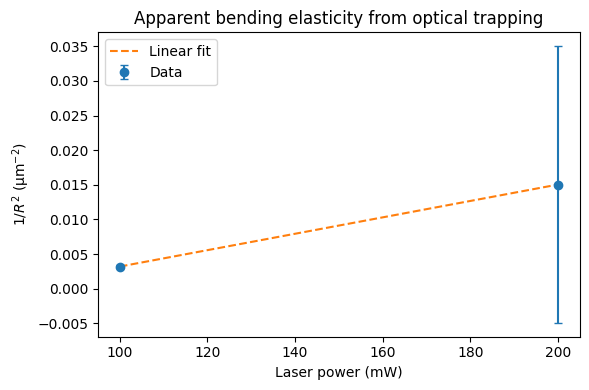

In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import linregress

# ======================================================
# USER PARAMETERS
# ======================================================
pixel_to_micron = 0.11      # µm / pixel (from microscope calibration)
min_edge_points = 500       # minimum edge pixels to accept a frame

# Explicit video list: (path, laser power in mW)
videos = [
    ("/content/20251219-12192025130649-0000.avi", 100),
    ("/content/20251219-12192025130808-0000.avi", 200),
    ("/content/20251219-12192025131417-0000.avi", 300),
    ("/content/20251219-12192025131519-0000.avi", 400),
    ("/content/20251219-12192025131723-0000.avi", 500),
    ("/content/20251219-12192025134547-0000.avi", 600),
    ("/content/20251219-12192025134848-0000.avi", 700),
    ("/content/20251219-12192025135156-0000.avi", 800),
    ("/content/20251219-12192025135318-0000.avi", 900),
    ("/content/20251219-12192025135012-0000.avi", 1000),
]
# ======================================================
# HELPER FUNCTIONS
# ======================================================
def extract_radii(video_path):
    """
    Extract curvature radii (in pixels) from all valid frames of a video.
    """
    cap = cv2.VideoCapture(video_path)
    radii = []

    while True:
        ret, frame = cap.read()
        if not ret:
            break

        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

        # Edge detection
        edges = cv2.Canny(gray, 50, 150)

        points = np.column_stack(np.where(edges > 0))
        if len(points) < min_edge_points:
            continue

        (_, _), radius = cv2.minEnclosingCircle(points)
        radii.append(radius)

    cap.release()
    return np.array(radii)


# ======================================================
# MAIN ANALYSIS
# ======================================================
powers = []
R_inv2 = []
R_err = []

print("Processing videos:\n")

for video_path, P in videos:
    radii_px = extract_radii(video_path)

    if len(radii_px) == 0:
        print(f"{P} mW | No valid frames")
        continue

    radii_um = radii_px * pixel_to_micron

    # Robust statistics
    R_med = np.median(radii_um)
    R_std = np.std(radii_um)

    powers.append(P)
    R_inv2.append(1.0 / R_med**2)
    R_err.append(2 * R_std / R_med**3)  # propagated error for 1/R^2

    print(f"{P:4.0f} mW | R = {R_med:.2f} ± {R_std:.2f} µm")

powers = np.array(powers)
R_inv2 = np.array(R_inv2)
R_err = np.array(R_err)

# ======================================================
# LINEAR FIT: 1/R^2 = (α/K) P
# ======================================================
slope, intercept, r, p, stderr = linregress(powers, R_inv2)

print("\nLinear fit results:")
print(f"slope      = {slope:.3e} µm⁻²/mW")
print(f"intercept  = {intercept:.3e}")
print(f"R²         = {r**2:.4f}")
print(f"std error  = {stderr:.3e}")

# Apparent modulus (relative, trap calibration unknown)
K_app_relative = 1 / slope
print(f"\nRelative apparent bending modulus ∝ {K_app_relative:.3e}")

# ======================================================
# PLOT
# ======================================================
plt.figure(figsize=(6, 4))

plt.errorbar(
    powers,
    R_inv2,
    yerr=R_err,
    fmt='o',
    capsize=3,
    label="Data"
)

P_fit = np.linspace(min(powers), max(powers), 200)
plt.plot(P_fit, slope * P_fit + intercept, '--', label="Linear fit")

plt.xlabel("Laser power (mW)")
plt.ylabel(r"$1/R^2$ (µm$^{-2}$)")
plt.title("Apparent bending elasticity from optical trapping")
plt.legend()
plt.tight_layout()
plt.show()
